In [1]:
import time

from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import DataProcessor, GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor, LocalPositionProcessor
from math import atan, tan, radians, degrees
import time
import numpy
from mavlink.mavlink.data import Gimbal
import cv2
from data_stream import StreamReceiver
from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
import math
from matplotlib import pyplot as plt
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
global_position_processor = GlobalPositionProcessor()
local_position_processor = LocalPositionProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(mavlink_connection, [attitude_processor, global_position_processor, local_position_processor, gimbal_processor])
acquisition_thread.start()


host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

GIMBAL [-1.3942242246099266e-07, -19.99999738369069, -54.999993099610535]


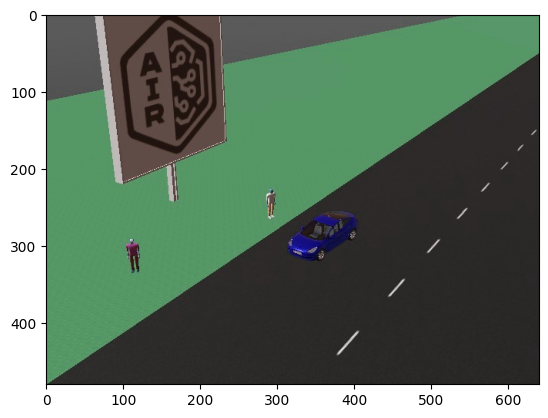

In [79]:
latest_data = gimbal_processor.queue.get_latest()
if latest_data:
    print("GIMBAL", [math.degrees(axis) for axis in latest_data.quaternion.to_euler()])

mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-23,
    yaw=-55
)

data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

plt.imshow(camera_frame)

In [80]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

model = YOLO("yolov8x.pt")

detection_threshold = 0.01

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=True
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

True

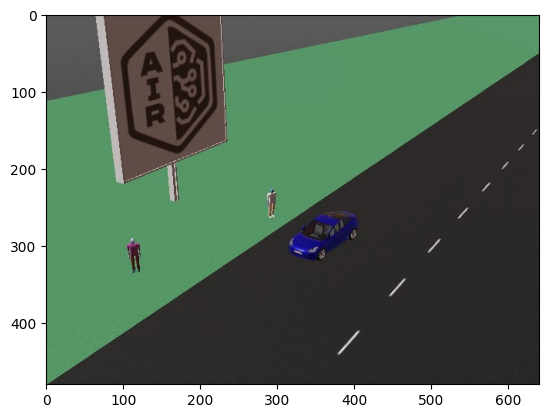

In [86]:
plt.imshow(camera_frame)
cv2.imwrite("camera_frame.png", camera_frame)

[64, 0, 238, 220, 0.9576498866081238, 11, 'stop sign']
[313, 254, 407, 320, 0.9402777552604675, 2, 'car']
[104, 290, 122, 335, 0.8864226937294006, 0, 'person']
[286, 225, 299, 265, 0.8351688385009766, 0, 'person']


True

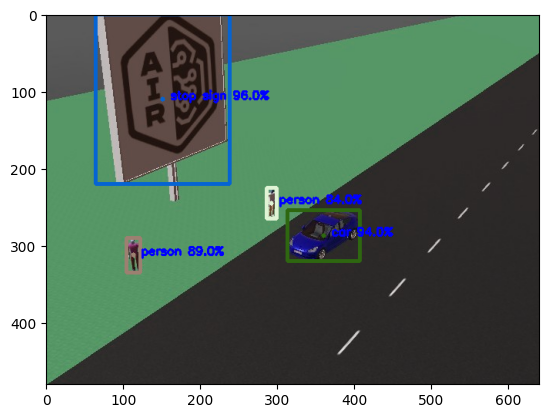

In [87]:
results = model.predict(
    camera_frame,
    verbose=False
)
result = results[0]

yolo_frame = camera_frame.copy()
detections = []
class_list = [0, 2]
for i, result in enumerate(result.boxes.data.tolist()):    
    x1, y1, x2, y2, score, class_id = result
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    class_id = int(class_id)    
    
    print([x1, y1, x2, y2, score, class_id, model.names[class_id]])
    
    if class_id in class_list:
        detections.append([x1, y1, x2, y2, score, class_id])
    
    color = colors[i % len(colors)]

    cv2.rectangle(
        yolo_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )
    
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    
    cv2.circle(
        yolo_frame,
        (cx, cy),
        3,
        color,
        -1
    )
    
    cv2.putText(
        yolo_frame,
        f"{model.names[class_id]} {round(score * 100, 0)}%",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    
plt.imshow(yolo_frame)
cv2.imwrite("yolo_frame.png", yolo_frame)

313.0 254.0 407.0 320.0 1 2
104.0 290.0 122.0 335.0 2 0
286.0 225.0 299.0 265.0 3 0


True

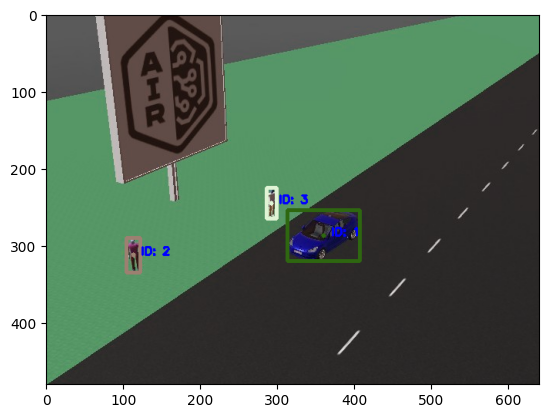

In [88]:
tracker = Tracker(
    feature_extractor=extractor
)

for i in range(10):
    tracker.update(camera_frame, detections)

sort_frame = camera_frame.copy()

for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id

    print(
        x1, y1, x2, y2, track_id, class_id
    )

    color = colors[track_id % len(colors)]

    cv2.rectangle(
        sort_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        sort_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        sort_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )

plt.imshow(sort_frame)
cv2.imwrite("sort_frame.png", sort_frame)

In [89]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import transform


def find_elevation(latitude, longitude, file_path="S36E149.hgt"):
    with rasterio.open(file_path) as src:
        transformed_point = transform(
            {'init': 'epsg:4326'},
            src.crs,
            [longitude], [latitude]
        )
        
        row, col = src.index(transformed_point[0][0], transformed_point[1][0])
        elevation = src.read(1, window=rasterio.windows.Window(col, row, 1, 1), resampling=Resampling.nearest)
        
        return elevation[0][0]


def find_target_location(global_position, gimbal, offset=None):    
    roll, pitch, yaw = gimbal.quaternion.to_euler()
    heading = math.radians(global_position.heading)  
    yaw = yaw + heading
    
    if offset:
        offset_roll, offset_pitch, offset_yaw = offset
        
        roll += offset_roll
        pitch += offset_pitch
        yaw += offset_yaw
    
    direction_vector = numpy.array([
        math.cos(pitch) * math.sin(yaw),
        math.cos(pitch) * math.cos(yaw),
        math.sin(pitch)
    ])
    
    distance_to_ground = global_position.relative_altitude / -direction_vector[2]
    
    target_enu = direction_vector * distance_to_ground
    
    earth_radius = 6371000
    latitude_change = target_enu[1] / earth_radius
    longitude_change = target_enu[0] / (earth_radius * math.cos(math.radians(global_position.latitude)))
    
    target_latitude = global_position.latitude + math.degrees(latitude_change)
    target_longitude = global_position.longitude + math.degrees(longitude_change)
    target_altitude = find_elevation(target_latitude, target_longitude)
    
    return target_latitude, target_longitude, target_altitude


def distance_between_locations(lat1, lon1, alt1, lat2, lon2, alt2):
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    lambda1, lambda2 = math.radians(lon1), math.radians(lon2)
    
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    delta_alt = alt2 - alt1
    
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    earth_radius = 6371000
    distance = earth_radius * c
    
    total_distance = math.sqrt(distance ** 2 + delta_alt ** 2)
    
    return total_distance


drone_latitude: -35.3633503 drone_longitude: 149.1653247 drone_altitude: 598.89
gimbal: Quaternion(w=0.8692038059234619, x=-0.09205786138772964, y=-0.17684151232242584, z=-0.4524788558483124)
target_latitude: -35.36310047244026 target_longitude: 149.16520322868328 target_altitude: 584 distance: 33.387796183317576
target_latitude: -35.36315688841991 target_longitude: 149.16513273063202 target_altitude: 585 distance: 30.959383362273467
target_latitude: -35.363073909805834 target_longitude: 149.16515640057264 target_altitude: 584 distance: 37.4051866196173


True

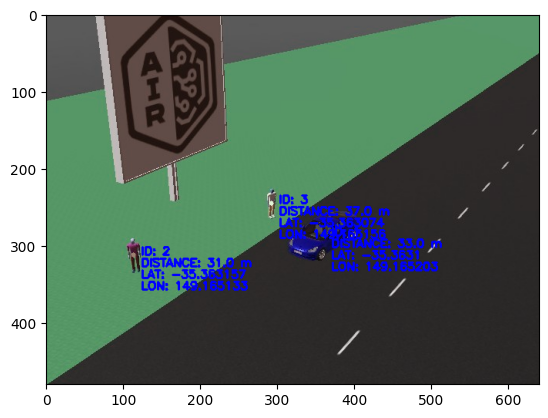

In [94]:
fov_vertical = 2 * atan(tan(drone_data.camera.fov * 0.5) * (drone_data.camera.height / drone_data.camera.width))

def find_center(x1, y1, x2, y2):
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    
    return center_x, center_y


global_position = global_position_processor.queue.get_latest()
gimbal = gimbal_processor.queue.get_latest()

print("drone_latitude:", global_position.latitude, 
      "drone_longitude:", global_position.longitude, 
      "drone_altitude:", global_position.altitude)
print("gimbal:", gimbal.quaternion)

geo_frame = camera_frame.copy()

for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id
    
    target_center_x, target_center_y = find_center(x1, y1, x2, y2)
    
    image_center_x, image_center_y = find_center(0, 0, drone_data.camera.width, drone_data.camera.height)
    
    offset_x = target_center_x - image_center_x
    offset_y = target_center_y - image_center_y
    
    offset_yaw = (offset_x / drone_data.camera.width) * drone_data.camera.fov
    offset_pitch = -(offset_y / drone_data.camera.height) * fov_vertical    
    
    target_latitude, target_longitude, target_altitude = find_target_location(
        global_position, 
        gimbal, 
        offset=[0, offset_pitch, offset_yaw]
    )
    distance = distance_between_locations(
        target_latitude, target_longitude, target_altitude, 
        global_position.latitude, global_position.longitude, global_position.altitude
    )
    
    print("target_latitude:", target_latitude, "target_longitude:", target_longitude, "target_altitude:", target_altitude, "distance:", distance)
    
    color = colors[track_id % len(colors)]

    # cv2.rectangle(
    #     geo_frame,
    #     (int(x1), int(y1)),
    #     (int(x2), int(y2)),
    #     color,
    #     3
    # )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        geo_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        geo_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"DISTANCE: {round(distance, 0)} m",
        (cx + 10, cy + 15),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"LAT: {round(target_latitude, 6)}",
        (cx + 10, cy + 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    cv2.putText(
        geo_frame,
        f"LON: {round(target_longitude, 6)}",
        (cx + 10, cy + 45),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )
    
    
    
plt.imshow(geo_frame)
cv2.imwrite("geo_frame.png", geo_frame)

In [91]:
print(global_position)
print(gimbal)

GlobalPosition(timestamp=1714531619.9505506, latitude=-35.3633503, longitude=149.1653247, altitude=598.89, relative_altitude=14.82, vx=-0.01, vy=0.0, vz=0.0, heading=17.73)
Gimbal(timestamp=1714531616.5303, flags=44, quaternion=Quaternion(w=0.8692038059234619, x=-0.09205786138772964, y=-0.17684151232242584, z=-0.4524788558483124))
